In [1]:
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats
from scipy import optimize
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstats
from astropy.visualization.hist import hist as fancyhist

from sklearn.neighbors import KernelDensity

import emcee
#import pymc3
import corner

#import dynesty

import sklearn
from sklearn import manifold
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift

# Dimensional reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA

## Noisy detector.

Three telescopes are monitoring the same astronomical event. Their time-series output is provided  at `solutions/noisydetector.npy`. These could be the outputs of three photometry CCD cameras we still need to calibrate, or the strain channel from a gravitational-wave detectors. 

Our detectors measure the following outputs, which to me just looks like a pile of junk. Someone really forgot to read the telescope manual here!

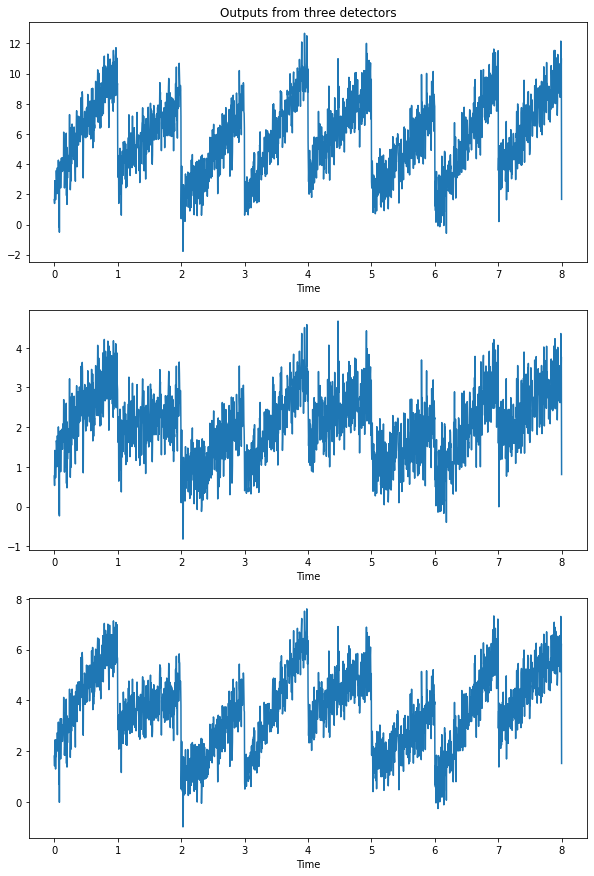

In [5]:
X=np.load('noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(10,15))

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');

In a realistic scenario, those jumps will have a physical meaning. Say for a satellite we need to [re-point the radio antennas](https://arxiv.org/abs/1907.04747) to send data down to Earth, and the whole thing shakes a bit. Or say the [the Starlink satellites](https://www.science.org/content/article/starlink-already-threatens-optical-astronomy-now-radio-astronomers-are-worried) are polluting your telescope data (I'm making this up, I don't really know what kind of data contamination they would cause!).


***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Your taks is to measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)...
3. ... and estimate the error on your measurement.
4. Compute the residuals between the identified signal and your best-fit model. How are the residual distributed?

### ICA approach

In [42]:
# try to separate the signal from the telescope problem: ICA task

ica = FastICA(n_components=2) # source and noise
ica.fit(X)

proj = ica.transform(X) # projection of the data
#comp = ica.components_  # matrix of independent components
#sources = ica.sources_  # matrix of sources

Text(0.5, 1.0, 'Signal isolation ICA result')

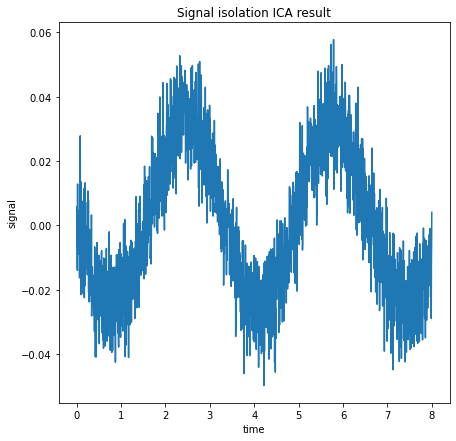

In [67]:
# separate the signal from the noise
signal = proj.T[1]

fig = plt.figure(figsize=(7,7))

plt.plot(time,signal)
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Signal isolation ICA result')

In [52]:
def sinusoidal(t,bg,A,t_0,T):
    return bg + A*np.sin(2*np.pi/T*(t+t_0))

The period of the cepheid is: ( 3.3096026131698544  +/- 0.007949211134297588 ) s


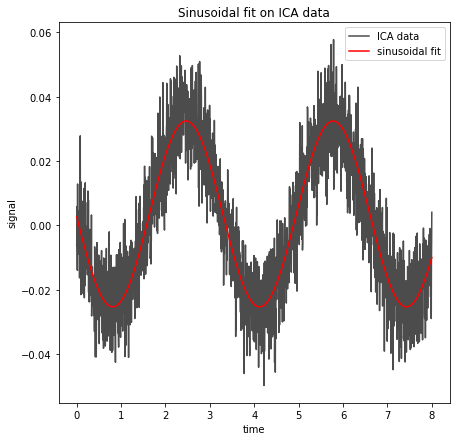

In [83]:
init_param = [0,0.08,0,3]

popt,pcov = scipy.optimize.curve_fit(sinusoidal,time,signal,init_param)

fig = plt.figure(figsize=(7,7))

sin_model = sinusoidal(time,*popt)

plt.plot(time,signal,color='black',label='ICA data',alpha=0.7)
plt.plot(time,sin_model,color='red',label='sinusoidal fit')
plt.xlabel('time')
plt.ylabel('signal')
plt.title('Sinusoidal fit on ICA data')
plt.legend()

print('The period of the cepheid is: (',popt[-1],' +/-',np.sqrt(pcov[-1,-1]), ') s')

Text(0, 0.5, 'counts')

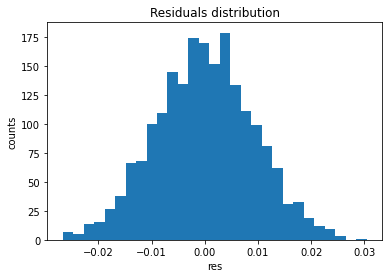

In [89]:
res = signal - sin_model
_ = fancyhist(res,bins='freedman')
plt.title('Residuals distribution')
plt.xlabel('res')
plt.ylabel('counts')

### PCA approach

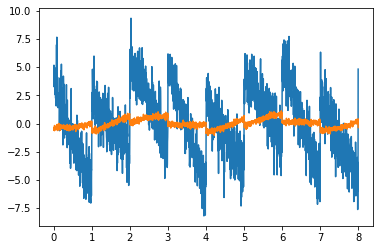

In [81]:
pca = PCA(n_components=2) # source and noise
pca.fit(X)

proj_pca = pca.transform(X) # projection of the data
#comp = ica.components_  # matrix of independent components
#sources = ica.sources_  # matrix of sources

plt.plot(time,proj_pca)

Both reductions are not good